Introduction
Intuition behind VAR Model Formula
Building a VAR model in Python
Import the datasets
Visualize the Time Series
Testing Causation using Granger’s Causality Test
Cointegration Test
Split the Series into Training and Testing Data
Check for Stationarity and Make the Time Series Stationary
How to Select the Order (P) of VAR model
Train the VAR Model of Selected Order(p)
Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
How to Forecast VAR model using statsmodels
Train the VAR Model of Selected Order(p)
Invert the transformation to get the real forecast
Plot of Forecast vs Actuals
Evaluate the Forecasts

In [2]:
pd.__version__

'2.2.3'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen


C:\Users\HP\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def data_read(filename: str):
    """
    Reads a excel file, sheet_name ="Variables exogènes uniques".
    """
    try:
        data = pd.read_excel(filename,sheet_name="Variables exogènes uniques",parse_dates=["Période"])
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

In [3]:
file_path = "C:/Users/HP/Desktop/PBR/PBR/VA/VA croissance PIB.xlsx"
df = data_read(file_path)

C:\Users\HP\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Sparkline Group extension is not supported and will be removed
  warn(msg)


In [4]:
# Clean 
def clean_column_names(df):
    """
    Cleans column names by:
    - Removing trailing spaces
    - Replacing spaces within composed column names with underscores
    
    """
    df = df.copy()  # Create a copy to avoid modifying the original DataFrame
    
    df.columns = [
        col.strip().replace(" ", "_") if " " in col.strip() else col.strip()
        for col in df.columns
    ]
    
    return df

In [5]:
pd.set_option('display.max_columns', 500)
cleaned_df = clean_column_names(df)
cleaned_df

,Période,PIB_réel,M4,USD/TND,Production_Industrielle_(IPI_2010_100),Exportations,Dette_Extérieure,Inflation,Dette_Intérieure,IDE,Industries_manufacturières,Industries_non_manufacturières,Avoirs_en_devise,Chomage,M3-M2,MaisUStm,PetrolebrutUSbaril,CafeUSKg,CuivreUStm,Certificats_de_depots,BléUStm,IPIAgroalimentaires,IPIIndustrieschimiques,Solde_budgetaire,TotalRecettes,TotalDepenses,IPIpourIndustriesmecaniqueetelectriques,IPIpourTextileHabillementetCuir,X10_year_pound,IPIpourIndustriesManifacturieresDiverses,Soldecommercial,TauxMoyenduMarcheMonetaire,Tunindex,IPC_base_2000,Importations,EURTND,Monnaie_Fiduciaire,Dette,Activitesdeservicesmarchands,dtDepterprod,Quasimonnaie,M2,M3,dtDepot_a_vue_bques,Rémunérations,Interventions_&_Transferts,charges_de_financement,PIB_reel_agriculture,IPC_base_2015_(ipc_corrigé_2015_),SMAG,PIBreelIndustriesAgroalimentaires,IPVIpourAutresindustriesalimentaires,IPVIpourTravaildelapierre,IPVIpourFabricationdautresproduitschimiques,IPVIpourFabricationdecimentchauxetplatre,IPVIpourMateriauxdeconstructionceramiqueetverre,IPVIpourIndustriedupapieretducarton,IPVIpourFabricationdeverreetdarticlesenverre,IPVIpourIndustriepharmaceutique,IPVIpourTransformationdesmatieresplastiques,IPVIpourIndustrietextile,PIBreelTextileHabillementetcuir,IPVIpourFabricationdemeublesetindustriesdiverses,IPVIpourFabricationdalimentspouranimaux,IPVIpourIndustriesdivers,ExportationIndustriesMecaniquesetElectriques,IPVIpourTravaildesmetaux,IPVIpourTravailduboisetfabricationdarticlesenbois,IPVIpourIndustriedesviandes,IPVIpourIndustrieducaoutchouc,IPVIpourFabricationdemachinesetappareilselectriques,IPVIpourindustriemanufacturiere,IPVIpourindustriesmecaniquesetelectriques,PIBreelIndustrieschimiques,IPVIpourChimie,IPVIpourIndustriechimiquedebase,IPVIpourFabricationdecarreauxenceramique,IPVIpourFabricationdepeinturesetvernis,IPVIpourIndustriedesfruitsetlegumes,IPIpourSavonsparfumsetproduitsdentretien,IPVIpourIndustrielaitiere,IPIpourPeinturesetvernis,ArgentUStoz,IPVIpourFabricationdautresmaterielsdetransport,IPIpourEnergie,PIBreelMateriauxdeconstructionceramiqueetverre,PIBreelIndustriesmecaniquesetelectriques,IPVIpourindustriesagroalimentaires,IPVIpourIndustriedupoisson,IPVI2010100,PIBreelRaffinagedepetrole,IPICimentchauxetplatre,OrUStoz,IPVIpourFabricationdetuilesetbriquesenterrecuite,IPVIpourFabricationdinstrumentsmedicauxdeprecisiondoptiqueetdhorlogerie,IPIpourExtractiondesablesetdargiles,IPIOuvragesencimentenbetonouenplatre,IPVIpourIndustrieducuiretdelachaussure,IPIpourIndustrietextile,IPIpourMetallurgie,PIBreelIndustriesdiverses,IPVIpourFabricationdesavonsdeparfumsetdeproduitsdentretien,ImpôtsDirects,GaznaturelUSmmbtu,PIBreelExtractiondepetroleetgaznaturel,IPVIpourCaptagetraitementetdistributiondeau,PIBreelMines,IPIpourMines,IPIpourMinérauxpourlindustriechimiqueetengraisnaturels,DépensesdeGestion,IPVIpourProductiondesel,PIBreelElectriciteetGaz,IPIpourProduitspetroliersraffinesetdelacokefaction,IPVIpourRaffinagedepetrole,IPVIpourProductionetdistributiondelectricite,PIBreelEau,IPVIpourExtractiondhydrocarbures,IPVIpourEnergie,CacaoUSKg,PIBreelBâtimentetgeniecivil,PIBreelActivitésdeservicesmarchands,PIBreelServicesdhôtellerieetderestauration,PIBreelTransports,ImportationsIndustriesMécaniquesetElectriques,ValeurtotaledesimportationsenMDT,PIBreelPosteettélécommunication,PIBreelServicesfinanciers,Monnaie_scripturale,PIBreelCommerce,PIBreelAutresServicesmarchands,EpargneCEP,PIBreelActivitesnonmarchandes,Encoursmicrocrédits
0,2000-01-01,9224.979865,14895.000000,1.277870,79.330000,NaN,NaN,56.414688,NaN,NaN,1333.646102,1074.616717,NaN,NaN,649.000000,94.496667,26.673656,2.316933,1794.733333,131.000000,106.486667,86.000000,86.000000,NaN,NaN,NaN,44.333333,107.000000,5.463667,69.000000,NaN,0.041267,1327.965000,99.500000,2671.7,1.261787,2040.000000,NaN,NaN,2.100465e+06,7204.000000,11862.000000,12511.000000,3.071368e+06,NaN,NaN,NaN,905.666678,50.822105,5.809,313.133329,78.200000,69.600000,74.400000,56.100000,62.066667,93.000000,77.100000,66.500000,84.

In [6]:
print(cleaned_df.columns)

Index(['Période', 'PIB_réel', 'M4', 'USD/TND',
       'Production_Industrielle_(IPI_2010_100)', 'Exportations',
       'Dette_Extérieure', 'Inflation', 'Dette_Intérieure', 'IDE',
       ...
       'ImportationsIndustriesMécaniquesetElectriques',
       'ValeurtotaledesimportationsenMDT', 'PIBreelPosteettélécommunication',
       'PIBreelServicesfinanciers', 'Monnaie_scripturale', 'PIBreelCommerce',
       'PIBreelAutresServicesmarchands', 'EpargneCEP',
       'PIBreelActivitesnonmarchandes', 'Encoursmicrocrédits'],
      dtype='object', length=133)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 133 entries, Période to Encoursmicrocrédits
dtypes: datetime64[ns](1), float64(132)
memory usage: 104.0 KB


Case 1: If the first non-NaN value of a predicted variable has a "Période" (date) earlier than the first valid date of another variable, that variable is dropped entirely.

Case 2: If the first non-NaN value of a predicted variable has a "Période" (date) later than the first valid date of another variable, the variable is kept, but its values are aligned with the earliest "Période" among the predicted variables (with NaN padding for missing rows).

In [ ]:
list_predicted_variables = list(["PIB_réel","Chomage","Solde_budgetaire","Soldecommercial","Dette",
                                 "PIB_reel_agriculture","IPC_base_2015_(ipc_corrigé_2015_)",
                                 "PIBreelIndustriesAgroalimentaires","PIBreelTextileHabillementetcuir",
                                 "PIBreelIndustrieschimiques","PIBreelMateriauxdeconstructionceramiqueetverre",
                                 "PIBreelIndustriesmecaniquesetelectriques","PIBreelRaffinagedepetrole",
                                 "PIBreelIndustriesdiverses","PIBreelExtractiondepetroleetgaznaturel",
                                "PIBreelMines","PIBreelElectriciteetGaz","PIBreelEau","PIBreelBâtimentetgeniecivil",
                                "PIBreelActivitésdeservicesmarchands","PIBreelServicesdhôtellerieetderestauration",
                                "PIBreelTransports","PIBreelPosteettélécommunication","PIBreelServicesfinanciers",
                                "PIBreelCommerce","PIBreelAutresServicesmarchands","PIBreelActivitesnonmarchandes",
                                ])
def create_cleaned_dfs_with_alignment(cleaned_df, list_predicted_variables):
    """
    Creates separate DataFrames for each predicted variable, starting from the first row
    where the predicted variable has a non-NaN value.
    
    For each predicted variable:
    - Finds the first non-NaN value of that variable
    - Creates a DataFrame starting from that point
    - Drops any variables that have NaN values at the predicted variable's start date
    - Maintains remaining columns in the output
    
    Args:
        cleaned_df (pd.DataFrame): Input DataFrame containing the data.
        list_predicted_variables (list): List of predicted variables to process.
    
    Returns:
        dict: Dictionary of DataFrames with keys as "df_<variable>".
        
    Raises:
        ValueError: If no valid values are found for a predicted variable.
    """
    # Input validation
    if not isinstance(cleaned_df, pd.DataFrame) or cleaned_df.empty:
        raise ValueError("Input DataFrame is empty or invalid")
    if not list_predicted_variables:
        raise ValueError("No predicted variables provided")
        
    # Create a copy to avoid modifying the original DataFrame
    df = cleaned_df.copy()
    
    # Ensure "Période" is a datetime column
    df["Période"] = pd.to_datetime(df["Période"], dayfirst=True)
    
    # Sort DataFrame by Période
    df = df.sort_values("Période")
    
    # Prepare the final DataFrames
    result_dfs = {}
    for predicted_var in list_predicted_variables:
        if predicted_var not in df.columns:
            continue
            
        # Find the first non-NaN value for this predicted variable
        first_valid_idx = df[predicted_var].first_valid_index()
        
        if first_valid_idx is None:
            continue
            
        # Get the corresponding period for this first valid value
        start_period = df.loc[first_valid_idx, "Période"]
        
        # Get all data from this period onwards
        var_df = df[df["Période"] >= start_period].copy()
        
        # Get the first row (corresponding to start_period)
        first_row = var_df.iloc[0]
        
        # Identify columns to keep: those that are not NaN in the first row
        # Always keep 'Période' and the predicted variable
        cols_to_keep = ['Période', predicted_var]
        other_cols = [col for col in var_df.columns 
                     if col not in ['Période', predicted_var]]
        
        # Add other columns that have valid values at the start date
        for col in other_cols:
            if pd.notna(first_row[col]):
                cols_to_keep.append(col)
        
        # Keep only the selected columns
        var_df = var_df[cols_to_keep]
        
        # Reset index
        var_df = var_df.reset_index(drop=True)
        
        result_dfs[f"df_{predicted_var}"] = var_df
    
    return result_dfs

In [9]:
dict_df_predicted_variables = create_cleaned_dfs_with_alignment(cleaned_df, list_predicted_variables)

# Access and print the resulting DataFrames
for name, df in dict_df_predicted_variables.items():
    print(f"DataFrame: {name}")
    df

DataFrame: df_PIB_réel
DataFrame: df_Chomage
DataFrame: df_Solde_budgetaire
DataFrame: df_Soldecommercial
DataFrame: df_Dette
DataFrame: df_PIB_reel_agriculture
DataFrame: df_IPC_base_2015_(ipc_corrigé_2015_)
DataFrame: df_PIBreelIndustriesAgroalimentaires
DataFrame: df_PIBreelTextileHabillementetcuir
DataFrame: df_PIBreelIndustrieschimiques
DataFrame: df_PIBreelMateriauxdeconstructionceramiqueetverre
DataFrame: df_PIBreelIndustriesmecaniquesetelectriques
DataFrame: df_PIBreelRaffinagedepetrole
DataFrame: df_PIBreelIndustriesdiverses
DataFrame: df_PIBreelExtractiondepetroleetgaznaturel
DataFrame: df_PIBreelMines
DataFrame: df_PIBreelElectriciteetGaz
DataFrame: df_PIBreelEau
DataFrame: df_PIBreelBâtimentetgeniecivil
DataFrame: df_PIBreelActivitésdeservicesmarchands
DataFrame: df_PIBreelServicesdhôtellerieetderestauration
DataFrame: df_PIBreelTransports
DataFrame: df_PIBreelPosteettélécommunication
DataFrame: df_PIBreelServicesfinanciers
DataFrame: df_PIBreelCommerce
DataFrame: df_PIBree

In [9]:
dict_df_predicted_variables.keys()

dict_keys(['df_PIB_réel', 'df_Chomage', 'df_Solde_budgetaire', 'df_Soldecommercial', 'df_Dette', 'df_PIB_reel_agriculture', 'df_IPC_base_2015_(ipc_corrigé_2015_)', 'df_PIBreelIndustriesAgroalimentaires', 'df_PIBreelTextileHabillementetcuir', 'df_PIBreelIndustrieschimiques', 'df_PIBreelMateriauxdeconstructionceramiqueetverre', 'df_PIBreelIndustriesmecaniquesetelectriques', 'df_PIBreelRaffinagedepetrole', 'df_PIBreelIndustriesdiverses', 'df_PIBreelExtractiondepetroleetgaznaturel', 'df_PIBreelMines', 'df_PIBreelElectriciteetGaz', 'df_PIBreelEau', 'df_PIBreelBâtimentetgeniecivil', 'df_PIBreelActivitésdeservicesmarchands', 'df_PIBreelServicesdhôtellerieetderestauration', 'df_PIBreelTransports', 'df_PIBreelPosteettélécommunication', 'df_PIBreelServicesfinanciers', 'df_PIBreelCommerce', 'df_PIBreelAutresServicesmarchands', 'df_PIBreelActivitesnonmarchandes'])

In [127]:
dict_df_predicted_variables.get('df_PIB_réel')

,Période,PIB_réel,M4,USD/TND,Production_Industrielle_(IPI_2010_100),Inflation,Industries_manufacturières,Industries_non_manufacturières,M3-M2,MaisUStm,PetrolebrutUSbaril,CafeUSKg,CuivreUStm,Certificats_de_depots,BléUStm,IPIAgroalimentaires,IPIIndustrieschimiques,IPIpourIndustriesmecaniqueetelectriques,IPIpourTextileHabillementetCuir,X10_year_pound,IPIpourIndustriesManifacturieresDiverses,TauxMoyenduMarcheMonetaire,Tunindex,IPC_base_2000,Importations,EURTND,Monnaie_Fiduciaire,dtDepterprod,Quasimonnaie,M2,M3,dtDepot_a_vue_bques,PIB_reel_agriculture,IPC_base_2015_(ipc_corrigé_2015_),SMAG,PIBreelIndustriesAgroalimentaires,IPVIpourAutresindustriesalimentaires,IPVIpourTravaildelapierre,IPVIpourFabricationdautresproduitschimiques,IPVIpourFabricationdecimentchauxetplatre,IPVIpourMateriauxdeconstructionceramiqueetverre,IPVIpourIndustriedupapieretducarton,IPVIpourFabricationdeverreetdarticlesenverre,IPVIpourIndustriepharmaceutique,IPVIpourTransformationdesmatieresplastiques,IPVIpourIndustrietextile,PIBreelTextileHabillementetcuir,IPVIpourFabricationdemeublesetindustriesdiverses,IPVIpourFabricationdalimentspouranimaux,IPVIpourIndustriesdivers,ExportationIndustriesMecaniquesetElectriques,IPVIpourTravaildesmetaux,IPVIpourTravailduboisetfabricationdarticlesenbois,IPVIpourIndustriedesviandes,IPVIpourIndustrieducaoutchouc,IPVIpourFabricationdemachinesetappareilselectriques,IPVIpourindustriemanufacturiere,IPVIpourindustriesmecaniquesetelectriques,PIBreelIndustrieschimiques,IPVIpourChimie,IPVIpourIndustriechimiquedebase,IPVIpourFabricationdecarreauxenceramique,IPVIpourFabricationdepeinturesetvernis,IPVIpourIndustriedesfruitsetlegumes,IPIpourSavonsparfumsetproduitsdentretien,IPVIpourIndustrielaitiere,IPIpourPeinturesetvernis,ArgentUStoz,IPVIpourFabricationdautresmaterielsdetransport,IPIpourEnergie,PIBreelMateriauxdeconstructionceramiqueetverre,PIBreelIndustriesmecaniquesetelectriques,IPVIpourindustriesagroalimentaires,IPVIpourIndustriedupoisson,IPVI2010100,PIBreelRaffinagedepetrole,IPICimentchauxetplatre,OrUStoz,IPVIpourFabricationdetuilesetbriquesenterrecuite,IPVIpourFabricationdinstrumentsmedicauxdeprecisiondoptiqueetdhorlogerie,IPIpourExtractiondesablesetdargiles,IPIOuvragesencimentenbetonouenplatre,IPVIpourIndustrieducuiretdelachaussure,IPIpourIndustrietextile,IPIpourMetallurgie,PIBreelIndustriesdiverses,IPVIpourFabricationdesavonsdeparfumsetdeproduitsdentretien,GaznaturelUSmmbtu,PIBreelExtractiondepetroleetgaznaturel,IPVIpourCaptagetraitementetdistributiondeau,PIBreelMines,IPIpourMines,IPIpourMinérauxpourlindustriechimiqueetengraisnaturels,IPVIpourProductiondesel,PIBreelElectriciteetGaz,IPIpourProduitspetroliersraffinesetdelacokefaction,IPVIpourRaffinagedepetrole,IPVIpourProductionetdistributiondelectricite,PIBreelEau,IPVIpourExtractiondhydrocarbures,IPVIpourEnergie,CacaoUSKg,PIBreelBâtimentetgeniecivil,PIBreelActivitésdeservicesmarchands,PIBreelServicesdhôtellerieetderestauration,PIBreelTransports,ValeurtotaledesimportationsenMDT,PIBreelPosteettélécommunication,PIBreelServicesfinanciers,Monnaie_scripturale,PIBreelCommerce,PIBreelAutresServicesmarchands,EpargneCEP,PIBreelActivitesnonmarchandes,Encoursmicrocrédits
0,2000-01-01,9224.979865,14895.000000,1.277870,79.330000,56.414688,1333.646102,1074.616717,649.000000,94.496667,26.673656,2.316933,1794.733333,131.000000,106.486667,86.000000,86.000000,44.333333,107.000000,5.463667,69.000000,0.041267,1327.965000,99.500000,2671.7,1.261787,2040.000000,2.100465e+06,7204.000000,11862.000000,12511.000000,3.071368e+06,905.666678,50.822105,5.809,313.133329,78.200000,69.600000,74.400000,56.100000,62.066667,93.000000,77.100000,66.500000,84.900000,84.766667,462.850256,80.900000,50.100000,84.000000,307.500000,65.700000,83.300000,71.666667,69.300000,40.966667,71.733333,68.866667,65.673226,65.100000,57.166667,90.600000,76.100000,92.400000,66.666667,63.500000,48.000000,5.166600,61.400000,90.333333,109.383687,237.078689,68.733333,74.400000,65.300000,5.005240,59.666667,290.190000,55.700000,58.400000,62.666667,63.0

In [12]:
# Just for testing ( removed last 2 rows that contains Na's)
dict_df_predicted_variables.get('df_PIB_réel').head(
    len(dict_df_predicted_variables.get('df_PIB_réel'))-2
)


In [13]:
dict_df_predicted_variables.get('df_PIB_réel').head(
    len(dict_df_predicted_variables.get('df_PIB_réel'))-2
).isna().sum()

Période                                   0
PIB_réel                                  0
M4                                        0
USD/TND                                   0
Production_Industrielle_(IPI_2010_100)    0
                                         ..
PIBreelCommerce                           0
PIBreelAutresServicesmarchands            0
EpargneCEP                                0
PIBreelActivitesnonmarchandes             0
Encoursmicrocrédits                       0
Length: 115, dtype: int64

# Granger Causality test

 Double Check data before the granger test (NaN checking and type)

In [10]:
pd.set_option('display.max_rows', 500)

df = dict_df_predicted_variables.get('df_PIB_réel')
variables = list(df.columns.drop('Période')) # Get variables (all columns except 'Période') from the DataFrame

# -2 to exclude the last two rows (just for testing)
data = df.head(len(df) - 2)

def check_data_before_granger(data, variables):
    """
    Helper function to check data before running Granger causality tests.
    """
    print("Data Types:")
    print(data[variables].dtypes)
    #print("\nSample of data:")
    #print(data[variables].head())
    print("\nChecking for NaN values:")
    print(data[variables].isna().sum())
    print("\nChecking for infinite values:")
    print(np.isinf(data[variables].values).sum())
    
# Use it before running the main function:
check_data_before_granger(data, variables)

Data Types:
PIB_réel                                                                   float64
M4                                                                         float64
USD/TND                                                                    float64
Production_Industrielle_(IPI_2010_100)                                     float64
Inflation                                                                  float64
Industries_manufacturières                                                 float64
Industries_non_manufacturières                                             float64
M3-M2                                                                      float64
MaisUStm                                                                   float64
PetrolebrutUSbaril                                                         float64
CafeUSKg                                                                   float64
CuivreUStm                                                                 

In [10]:
def grangers_causation_matrix(data, predicted_variable, variables=None, maxlag=12, test='ssr_chi2test', 
                            significance_level=0.05, verbose=False, min_observations=30):
    """
    Compute Granger Causality of all variables with respect to a single "predicted variable".
    
    Args:
        data (pd.DataFrame): DataFrame containing time series data.
        predicted_variable (str): The target variable to test for Granger causality.
        variables (list, optional): List of potential causal variables to test. If None, 
                                  will use all columns except 'Période' and predicted_variable.
        maxlag (int): Maximum number of lags to consider in the Granger causality test.
        test (str): Granger causality test statistic ('ssr_chi2test', 'lrtest', 'ssr_ftest').
        significance_level (float): Significance level to filter results (default: 0.05).
        verbose (bool): If True, print detailed P-values for each test.
        min_observations (int): Minimum number of observations required (default: 30).
    
    Returns:
        pd.DataFrame: Results DataFrame containing:
            - Variable: Name of the potential causal variable
            - P_Value: Minimum p-value across all tested lags
            - Significant: Whether the relationship is significant
            - Optimal_Lag: Lag with the lowest p-value
    """
    # Input validation
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    
    # Create a copy of the data
    data_clean = data.copy()
    
    # If variables not specified, use all columns except 'Période' and predicted_variable
    if variables is None:
        variables = [col for col in data_clean.columns 
                    if col not in ['Période', predicted_variable]]
    
    # Convert any string numbers with commas to float
    for col in variables + [predicted_variable]:
        if data_clean[col].dtype == 'object':
            data_clean[col] = data_clean[col].str.replace(',', '').astype(float)
    
    # Remove rows with any NaN values in the variables of interest
    data_clean = data_clean[variables + [predicted_variable]].dropna()
    
    # Check if we have enough data after cleaning
    if len(data_clean) <= max(maxlag, min_observations):
        raise ValueError(f"Insufficient data points after cleaning. Need more than max({maxlag}, {min_observations}) observations")
    
    # Initialize results storage
    results = []
    
    # Perform Granger causality tests
    for var in variables:
        try:
            # Prepare data for this specific test
            test_data = data_clean[[predicted_variable, var]].copy()
            
            # Verify no infinite values
            if np.any(np.isinf(test_data.values)):
                if verbose:
                    print(f"Infinite values found in {var}")
                continue
            
            # Perform Granger causality test
            test_result = grangercausalitytests(test_data, maxlag=maxlag, verbose=False)
            
            # Extract P-values for each lag
            p_values = [round(test_result[i + 1][0][test][1], 4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            optimal_lag = np.argmin(p_values) + 1
            
            if verbose:
                print(f'\nTesting if {var} causes {predicted_variable}:')
                print(f'P-values across lags: {p_values}')
                print(f'Minimum p-value: {min_p_value} at lag {optimal_lag}')
            
            results.append({
                'Variable': var,
                'P_Value': min_p_value,
                'Significant': min_p_value < significance_level,
                'Optimal_Lag': optimal_lag
            })
            
        except Exception as e:
            if verbose:
                print(f"\nError testing causality from {var} to {predicted_variable}:")
                print(f"Error message: {str(e)}")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    if len(results_df) > 0:
        results_df = results_df.sort_values('P_Value')
    
    return results_df

In [11]:
variables = list(dict_df_predicted_variables.get('df_PIB_réel').head(len(dict_df_predicted_variables.get('df_PIB_réel'))-2).columns.drop("Période"))
variables

['PIB_réel',
 'M4',
 'USD/TND',
 'Production_Industrielle_(IPI_2010_100)',
 'Inflation',
 'Industries_manufacturières',
 'Industries_non_manufacturières',
 'M3-M2',
 'MaisUStm',
 'PetrolebrutUSbaril',
 'CafeUSKg',
 'CuivreUStm',
 'Certificats_de_depots',
 'BléUStm',
 'IPIAgroalimentaires',
 'IPIIndustrieschimiques',
 'IPIpourIndustriesmecaniqueetelectriques',
 'IPIpourTextileHabillementetCuir',
 'X10_year_pound',
 'IPIpourIndustriesManifacturieresDiverses',
 'TauxMoyenduMarcheMonetaire',
 'Tunindex',
 'IPC_base_2000',
 'Importations',
 'EURTND',
 'Monnaie_Fiduciaire',
 'dtDepterprod',
 'Quasimonnaie',
 'M2',
 'M3',
 'dtDepot_a_vue_bques',
 'PIB_reel_agriculture',
 'IPC_base_2015_(ipc_corrigé_2015_)',
 'SMAG',
 'PIBreelIndustriesAgroalimentaires',
 'IPVIpourAutresindustriesalimentaires',
 'IPVIpourTravaildelapierre',
 'IPVIpourFabricationdautresproduitschimiques',
 'IPVIpourFabricationdecimentchauxetplatre',
 'IPVIpourMateriauxdeconstructionceramiqueetverre',
 'IPVIpourIndustriedupapier

In [12]:
# EXCLUDING the last two rows
df = dict_df_predicted_variables.get('df_PIB_réel')
data = df.head(len(df) - 2)

# Run the Granger causality tests
granger_test_result = grangers_causation_matrix(
    data=data,
    predicted_variable='PIB_réel',
    maxlag=5,
    significance_level=0.05,
    verbose=False
)

# View results
print("\nResults:")
granger_test_result


Results:


,Variable,P_Value,Significant,Optimal_Lag
73,PIBreelRaffinagedepetrole,0.0000,True,3
94,IPVIpourRaffinagedepetrole,0.0000,True,5
61,IPVIpourIndustriedesfruitsetlegumes,0.0000,True,3
105,PIBreelPosteettélécommunication,0.0001,True,2
91,IPVIpourProductiondesel,0.0004,True,4
...,...,...,...,...
83,PIBreelIndustriesdiverses,0.8120,False,2
45,IPVIpourFabricationdemeublesetindustriesdiverses,0.8556,False,3
19,TauxMoyenduMarcheMonetaire,0.9050,False,2
87,IPVIpourCaptagetraitementetdistributiondeau,0.9215,False,1


In [14]:
list_signif_grang=granger_test_result[granger_test_result["Significant"]==True]["Variable"].to_list()
data[list_signif_grang]

,PIBreelRaffinagedepetrole,IPVIpourRaffinagedepetrole,IPVIpourIndustriedesfruitsetlegumes,PIBreelPosteettélécommunication,IPVIpourProductiondesel,PIBreelIndustriesAgroalimentaires,IPIpourProduitspetroliersraffinesetdelacokefaction,EURTND,IPVIpourIndustrieducuiretdelachaussure,IPIAgroalimentaires,IPVIpourFabricationdautresmaterielsdetransport,ValeurtotaledesimportationsenMDT,IPVIpourindustriemanufacturiere,Monnaie_Fiduciaire,Quasimonnaie,IPVI2010100,IPVIpourFabricationdeverreetdarticlesenverre,PIBreelCommerce,PIBreelAutresServicesmarchands,M3,PIBreelElectriciteetGaz,IPIpourTextileHabillementetCuir,IPVIpourExtractiondhydrocarbures,IPIpourIndustrietextile,IPVIpourIndustriesdivers,PIBreelIndustriesmecaniquesetelectriques,dtDepterprod,IPIpourEnergie,IPIpourIndustriesManifacturieresDiverses
0,5.005240,31.466667,92.400000,114.356880,74.200000,313.133329,255.666667,1.261787,84.900000,86.000000,61.400000,2671.700000,71.733333,2040.000000,7204.000000,65.300000,77.100000,1010.605848,469.486895,12511.000000,89.836119,107.000000,69.900000,100.333333,84.000000,237.078689,2.100465e+06,90.333333,69.000000
1,5.118860,34.733333,92.400000,114.061297,74.200000,282.676919,254.333333,1.266710,84.266667,73.000000,61.400000,3197.500000,71.700000,2085.000000,7300.000000,65.300000,77.200000,1014.073114,471.953126,12827.000000,89.985215,113.333333,71.500000,114.333333,83.133333,257.671403,1.961621e+06,85.666667,70.666667
2,5.136800,35.300000,92.400000,118.172582,74.200000,303.743499,283.000000,1.263960,84.766667,86.000000,61.400000,2874.900000,71.900000,2097.000000,7702.000000,65.700000,80.466667,1063.319405,476.424726,13448.000000,90.810977,116.666667,72.333333,100.333333,82.833333,258.697459,2.300778e+06,88.666667,71.666667
3,5.157730,35.300000,92.400000,126.146595,74.200000,295.026294,276.000000,1.261297,87.266667,74.666667,61.400000,2671.700000,72.500000,2228.000000,8423.000000,66.266667,82.300000,1093.634800,484.365242,14538.000000,92.129904,120.000000,73.500000,116.000000,82.800000,259.126971,2.704667e+06,89.000000,71.333333
4,5.299138,35.300000,92.400000,139.465172,74.200000,295.247965,263.666667,1.283597,87.233333,79.666667,61.400000,3418.600000,73.266667,2249.000000,8557.000000,66.866667,82.500000,1145.995977,499.203578,14703.000000,94.640796,129.666667,72.233333,121.666667,82.933333,294.074508,2.432292e+06,91.000000,73.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,21.200000,203.400000,172.200000,883.700000,249.433333,784.100000,92.033333,3.350367,175.033333,112.600000,251.700000,20496.969788,186.600000,19224.000000,64639.000000,187.066667,200.400000,2783.700000,1419.600000,108901.000000,232.100000,101.266667,206.700000,101.000000,185.100000,994.700000,1.832600e+07,65.766667,111.033333
94,25.400000,199.343786,172.200000,888.200000,254.729580,781.500000,131.466667,3.368967,175.033333,124.866667,278.400000,19481.371690,190.133333,19220.000000,66583.000000,187.866667,200.400000,2786.200000,1430.200000,110319.000000,278.000000,93.000000,209.517038,100.233333,181.766667,998.200000,1.897900e+07,75.833333,110.300000
95,29.600000,202.121604,175.733333,895.500000,260.161973,791.900000,180.433333,3.375333,175.033333,114.733333,278.400000,19341.950227,192.664107,19932.000000,68577.000000,190.800000,200.400000,2794.200000,1441.000000,114269.000000,261.600000,92.200000,211.990496,97.700000,181.633333,1027.700000,1.877100e+07,67.333333,114.833333
96,27.700000,199.690554,177.700000,898.400000,260.940288,809.000000,173.233333,3.379900,175.233333,125.100000,278.140250,19341.950227,192.528658,20399.151151,68909.433394,190.797284,200.401643,2779.300000,1448.500000,116004.678583,237.700000,95.800000,212.445819,95.800000,181.633333,981.200000,1.876463e+07,60.366667,103.766667


# Cointegration Test

 #### Johanssen Test :
 #### Test the presence of a statistically significant connection between two or more time series.

    Automatically splits variables into batches of 12 or fewer
    Processes each batch separately using the original cointegration test
    Combines the results into a single DataFrame
    Adds batch numbers to track which variables were tested together
    Provides a summary of overall cointegration findings

In [34]:
def cointegration_test(df, alpha=0.05, max_lags=5):
    """
    Perform Johansen's Cointegration Test with DataFrame output.
    """
    import numpy as np
    import pandas as pd
    from statsmodels.tsa.vector_ar.vecm import coint_johansen
    from sklearn.preprocessing import StandardScaler
    
    # Input validation
    if len(df.columns) < 2:
        raise ValueError("Need at least two variables for cointegration test")
    
    # Check for non-numeric data
    if not all(df[col].dtype.kind in 'inf' for col in df.columns):
        raise ValueError("All variables must be numeric for cointegration test")
    
    # Remove any rows with NaN values
    df_clean = df.dropna()
    
    if len(df_clean) < max_lags + 2:
        raise ValueError(f"Insufficient observations after removing NaN values")
    
    try:
        # Standardize the data
        scaler = StandardScaler()
        df_scaled = pd.DataFrame(
            scaler.fit_transform(df_clean),
            columns=df_clean.columns,
            index=df_clean.index
        )
        
        # Perform Johansen test
        best_lag = 1  # Start with lag 1
        johanson = coint_johansen(df_scaled, det_order=0, k_ar_diff=best_lag)
        
        # Collect results in a DataFrame
        results_data = {
            'Variable': df_clean.columns,
            'Test_Statistic': johanson.lr1,
            'Critical_Value_95': johanson.cvt[:, 1]
        }
        
        results_df = pd.DataFrame(results_data)
        results_df['Is_Cointegrated'] = results_df['Test_Statistic'] > results_df['Critical_Value_95']
        
        return results_df
        
    except Exception as e:
        print(f"Error: {str(e)}")
        return None

def batch_cointegration_test(df, alpha=0.05, max_lags=5, batch_size=12):
    """
    Perform batched cointegration tests and return combined DataFrame results.
    """
    import pandas as pd
    
    if len(df.columns) <= batch_size:
        return cointegration_test(df, alpha, max_lags)
    
    all_results = []
    columns = list(df.columns)
    n_batches = (len(columns) + batch_size - 1) // batch_size
    
    for i in range(n_batches):
        batch_columns = columns[i * batch_size : (i + 1) * batch_size]
        if len(batch_columns) < 2:
            continue
            
        batch_df = df[batch_columns]
        batch_results = cointegration_test(batch_df, alpha, max_lags)
        
        if batch_results is not None:
            batch_results['Batch'] = i + 1
            all_results.append(batch_results)
    
    if not all_results:
        return None
        
    # Combine all results into a single DataFrame
    final_results = pd.concat(all_results, ignore_index=True)
    
    # Format the results
    final_results = final_results.round(4)
    final_results = final_results.sort_values('Is_Cointegrated', ascending=False)
    
    return final_results

##### List of Non cointegrated variables (list_non_cointegrated)

In [38]:
# Run the test and get results as DataFrame
coint_results_df = batch_cointegration_test(data[list_signif_grang])
#coint_results_df
list_non_cointegrated = coint_results_df[~coint_results_df['Is_Cointegrated']]['Variable'].tolist()
list_non_cointegrated

['EURTND',
 'PIBreelElectriciteetGaz',
 'IPIpourEnergie',
 'dtDepterprod',
 'PIBreelIndustriesmecaniquesetelectriques',
 'IPVIpourIndustriesdivers',
 'IPIpourIndustrietextile',
 'IPVIpourExtractiondhydrocarbures',
 'IPIpourTextileHabillementetCuir',
 'PIBreelAutresServicesmarchands',
 'M3',
 'IPVIpourIndustrieducuiretdelachaussure',
 'PIBreelCommerce',
 'IPIpourProduitspetroliersraffinesetdelacokefaction',
 'ValeurtotaledesimportationsenMDT',
 'IPVIpourFabricationdautresmaterielsdetransport',
 'IPIAgroalimentaires',
 'IPIpourIndustriesManifacturieresDiverses']

#### Checking correlation between the non cointegrated variables

In [43]:
def plot_correlation_noncointegrated(data, coint_results_df, method='pearson', figsize=(14, 10), cmap='coolwarm'):
    """
    Plot correlation matrix for non-cointegrated variables.
    method (str): Correlation method ('pearson', 'kendall', 'spearman')
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # Get non-cointegrated variables
    non_cointegrated = coint_results_df[~coint_results_df['Is_Cointegrated']]['Variable'].tolist()
    
    # Calculate correlation matrix
    corr_matrix = data[non_cointegrated].corr(method=method).round(3)
    
    # Create plot
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, annot=True, cmap=cmap, center=0, fmt='.2f', 
                square=True, mask=np.triu(np.ones_like(corr_matrix), k=1))
    plt.title(f'{method.capitalize()} Correlation Matrix for Non-cointegrated Variables')
    plt.tight_layout()
    plt.show()

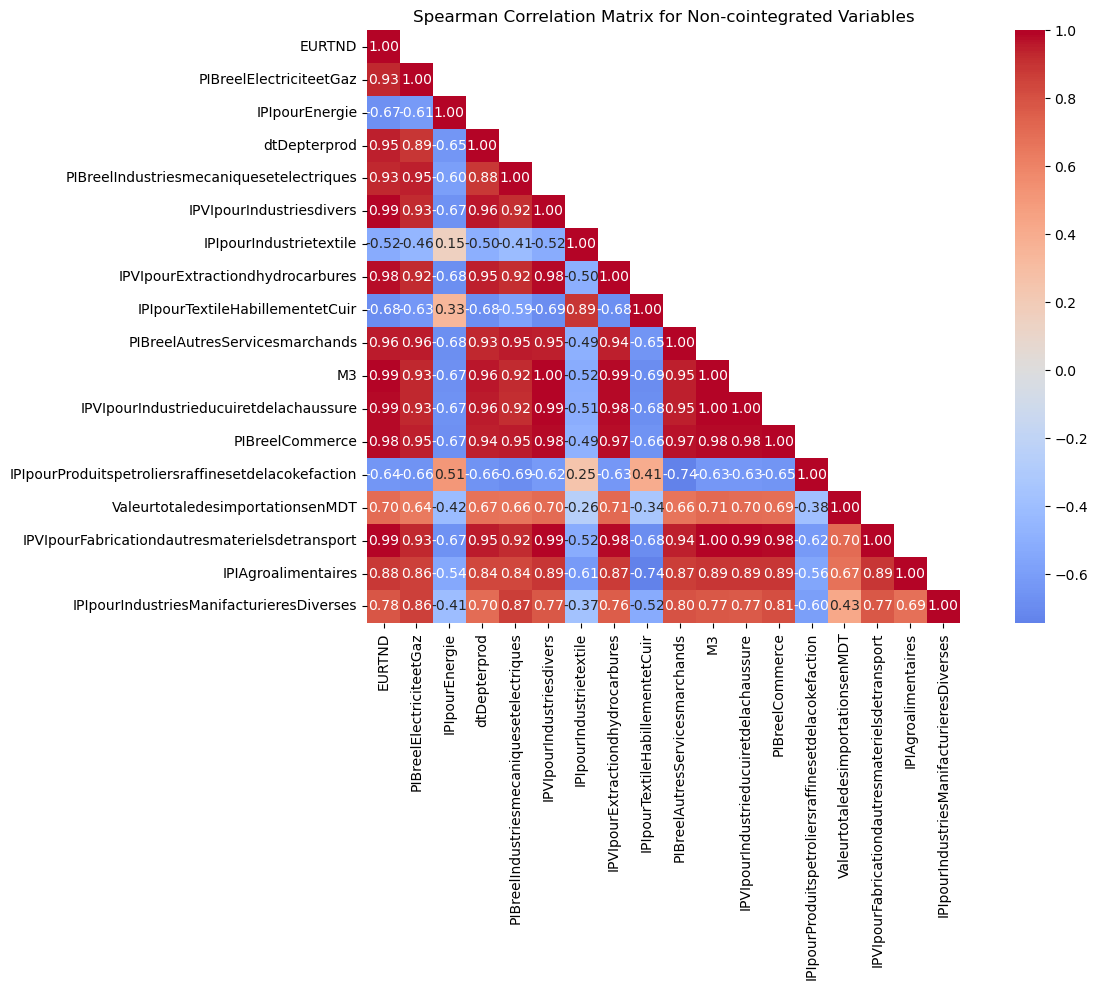

In [46]:
plot_correlation_noncointegrated(data, coint_results_df,method="spearman")